# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [26]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [27]:
%matplotlib inline

In [28]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [29]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [30]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [31]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [32]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

### Load within-topics and cross-topics data

In [33]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

# within has "is_same_side" as string (boolean after latest update)
# cross has "is_same_side" as boolean (auto cast?)

with Timer("read cross"):
    # cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'),
                                quotechar='"',
                                quoting=csv.QUOTE_ALL,
                                encoding='utf-8',
                                escapechar='\\',
                                doublequote=False,
                                index_col='id')

with Timer("read within"):
    # within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'),
                                 quotechar='"',
                                 quoting=csv.QUOTE_ALL,
                                 encoding='utf-8',
                                 escapechar='\\',
                                 doublequote=False,
                                 index_col='id')

Time for [read cross]: 0:00:01.109898
Time for [read within]: 0:00:01.097638


In [34]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.progress_apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.progress_apply(add_tag, axis=1)

  1%|          | 201/34330 [00:00<00:17, 2003.61it/s]

Time for [tag cross traindev]: 0:00:37.302910


  0%|          | 186/63903 [00:00<00:34, 1854.44it/s]

Time for [tag cross test]: 0:00:21.019828


  1%|          | 200/31475 [00:00<00:15, 1991.22it/s]

Time for [tag within traindev]: 0:00:38.933426


100%|██████████| 31475/31475 [00:18<00:00, 1691.41it/s]

Time for [tag within test]: 0:00:18.611405


### Get an overview about each dataset

In [35]:
# requires nltk  wordtokenize
# from nltk.tokenize import sent_tokenize, word_tokenize
# model uses BERT Tokenizer ...

def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')
    
    return

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [ ]:
with Timer("overview cross"):
    get_overview(cross_traindev_df)

In [ ]:
with Timer("overview within"):
    get_overview(within_traindev_df)

##### Count raw length

In [ ]:
def compute_arg_len(row):
    row['argument1_len'] = len(row['argument1'])
    row['argument2_len'] = len(row['argument2'])
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    return row


cross_traindev_df = cross_traindev_df.progress_apply(compute_arg_len, axis=1)
within_traindev_df = within_traindev_df.progress_apply(compute_arg_len, axis=1)
cross_test_df = cross_test_df.progress_apply(compute_arg_len, axis=1)
within_test_df = within_test_df.progress_apply(compute_arg_len, axis=1)

In [ ]:
cross_traindev_df.describe()

In [ ]:
within_traindev_df.describe()

##### Tokenize and count tokens

In [ ]:
ctx = mx.cpu()
_, vocabulary = nlp.model.get_model('bert_12_768_12',
                                    dataset_name='book_corpus_wiki_en_uncased',
                                    pretrained=True, ctx=ctx, use_pooler=True,
                                    use_decoder=False, use_classifier=False)
bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
tokenizer = bert_tokenizer

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punct')


# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    return row


cross_traindev_df = cross_traindev_df.progress_apply(tokenize_arguments, axis=1)
within_traindev_df = within_traindev_df.progress_apply(tokenize_arguments, axis=1)
cross_test_df = cross_test_df.progress_apply(tokenize_arguments, axis=1)
within_test_df = within_test_df.progress_apply(tokenize_arguments, axis=1)

In [ ]:
cross_traindev_df.describe()

In [ ]:
within_traindev_df.describe()

In [ ]:
def plot_lengths(df, slicen=None, abs_diff=True, title=None):
    if df is None:
        print("no lengths to plot")
        return
    
    arg1_lens = df['argument1_len']
    arg2_lens = df['argument2_len']
    arg_diff_len = df['argument12_len_diff']
    
    if abs_diff:
        arg_diff_len = np.abs(arg_diff_len)
    
    if slicen is not None:
        arg1_lens = arg1_lens[slicen]
        arg2_lens = arg2_lens[slicen]
        arg_diff_len = arg_diff_len[slicen]

    x = np.arange(len(arg1_lens))  # arange/linspace

    plt.subplot(2, 1, 1)
    plt.plot(x, arg1_lens, label='argument1')  # Linie: '-', 'o-', '.-'
    plt.plot(x, arg2_lens, label='argument2')  # Linie: '-', 'o-', '.-'
    plt.legend()
    plt.title('Lengths of arguments' if not title else title)
    plt.ylabel('Lengths of arguments 1 and 2')

    plt.subplot(2, 1, 2)
    plt.plot(x, arg_diff_len)
    plt.xlabel('Index')
    plt.ylabel('Differences')

    plt.show()


plot_lengths(within_traindev_df, slice(None, None, 500), title='Length of arguments within train/dev, every 500')
plot_lengths(cross_traindev_df, slice(None, None, 500), title='Length of arguments cross train/dev, every 500')
plot_lengths(within_test_df, slice(None, None, 1), title='Length of arguments within test')

## Train model - Baseline

### train dev set - 70% 30%

In [36]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [37]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())

    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([
                    row['argument1'], row['argument2'],
                    "1" if str(row['is_same_side']) == "True" else "0"
                ])
                #allsamples.append([row['argument1'], row['argument2'], 1 if str(row['is_same_side']) == "True" else 0])

        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])

        return allsamples

**TODO**: my own `BERTDatasetTransform` for extracting chunks from arguments or last part etc.

```python
transform = dataset.BERTDatasetTransform(bert_tokenizer, 512,
                                         labels=['0', '1'],
                                         label_dtype='int32',
                                         pad=True,
                                         pair=True)
```

http://localhost:9001/edit/bert/dataset.py @454
```python
# substitute with my own (e. g. last part, many parts etc.)
def __init__(...):
    self._bert_xform = BERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)
```
https://gluon-nlp.mxnet.io/master/_modules/gluonnlp/data/transforms.html#BERTSentenceTransform
```python
# substitute with my own (e. g. only last part (trim from start))
self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
```

https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html#Dataset.transform

In [38]:
from gluonnlp.data import BERTSentenceTransform


class FirstAndLastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(FirstAndLastPartBERTSentenceTransform,
              self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer(text_a)
        tokens_a_epi = tokens_a.copy()
        tokens_b = None
        tokens_b_epi = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)
            tokens_b_epi = tokens_b.copy()

        if tokens_b:
            self._truncate_seq_pair_prolog(tokens_a, tokens_b,
                                           self._max_seq_length - 3)
            self._truncate_seq_pair_epilog(tokens_a_epi, tokens_b_epi,
                                           self._max_seq_length - 3)
        else:
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]
            if len(tokens_a_epi) > self._max_seq_length - 2:
                tokens_a_epi = tokens_a_epi[0:(self._max_seq_length - 2)]

        vocab = self._tokenizer.vocab
        tokens, tokens_epi = [], []
        tokens.append(vocab.cls_token)
        tokens_epi.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens_epi.extend(tokens_a_epi)
        tokens.append(vocab.sep_token)
        tokens_epi.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)
        segment_ids_epi = [0] * len(tokens_epi)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens_epi.extend(tokens_b_epi)
            tokens.append(vocab.sep_token)
            tokens_epi.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))
            segment_ids_epi.extend([1] * (len(tokens) - len(segment_ids_epi)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)
        input_ids_epi = self._tokenizer.convert_tokens_to_ids(tokens_epi)
        valid_length = len(input_ids)
        valid_length_epi = len(input_ids_epi)

        if self._pad:
            padding_length = self._max_seq_length - valid_length
            padding_length_epi = self._max_seq_length - valid_length_epi
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            input_ids_epi.extend([vocab[vocab.padding_token]] *
                                 padding_length_epi)
            segment_ids.extend([0] * padding_length)
            segment_ids_epi.extend([0] * padding_length_epi)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32'), np.array(input_ids_epi, dtype='int32'),\
            np.array(valid_length_epi, dtype='int32'), np.array(segment_ids_epi, dtype='int32')

    def _truncate_seq_pair_prolog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()

    def _truncate_seq_pair_epilog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)

In [39]:
class FirstAndLastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self,
                 tokenizer,
                 max_seq_length,
                 labels=None,
                 pad=True,
                 pair=True,
                 label_dtype='float32'):
        super(FirstAndLastPartBERTDatasetTransform,
              self).__init__(tokenizer,
                             max_seq_length,
                             labels=labels,
                             pad=pad,
                             pair=pair,
                             label_dtype=label_dtype)
        self._bert_xform = FirstAndLastPartBERTSentenceTransform(
            tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi = self._bert_xform(
            line[:-1])

        label = line[-1]
        if self.labels:  # for classification task
            label = self._label_map[label]
        label = np.array([label], dtype=self.label_dtype)

        return input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi, label

In [40]:
from mxnet.gluon import Block
from mxnet.gluon import nn


class BERTProEpiClassifier(Block):
    """Model for sentence (pair) classification task with BERT.

    The model feeds token ids and token type ids into BERT to get the
    pooled BERT sequence representation, then apply a Dense layer for
    classification. Does this also for an adversarial classifier.

    Parameters
    ----------
    bert: BERTModel
        Bidirectional encoder with transformer.
    num_classes : int, default is 2
        The number of target classes.
    dropout : float or None, default 0.0.
        Dropout probability for the bert output.
    prefix : str or None
        See document of `mx.gluon.Block`.
    params : ParameterDict or None
        See document of `mx.gluon.Block`.
    """

    def __init__(self,
                 bert,
                 num_classes=2,
                 dropout=0.0,
                 prefix=None,
                 params=None):
        super(BERTProEpiClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))
            self.classifier.add(nn.Dense(units=num_classes))

    def forward(self,
                inputs,
                token_types,
                valid_length=None,
                inputs_epi=None,
                token_types_epi=None,
                valid_length_epi=None):  # pylint: disable=arguments-differ
        """Generate the unnormalized scores for the given the input sequences.
        From both classifiers (classifier + adversarial_classifier).

        Parameters
        ----------
        inputs : NDArray, shape (batch_size, seq_length)
            Input words for the sequences.
        token_types : NDArray, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one.
        valid_length : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.
        inputs_epi : NDArray or None, shape (batch_size, seq_length)
            Input words for the sequences. If None then same as inputs.
        token_types_epi : NDArray or None, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one. If None then same as token_types.
        valid_length_epi : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.

        Returns
        -------
        outputs : NDArray
            Shape (batch_size, num_classes), outputs of classifier.
        """
        # if inputs_epi is None and token_types_epi is None:
        #     inputs_epi = inputs
        #     token_types_epi = token_types
        #     valid_length_epi = valid_length

        _, pooler_out = self.bert(inputs, token_types, valid_length)
        _, pooler_out_epi = self.bert(inputs_epi, token_types_epi, valid_length_epi)
        pooler_concat = mx.nd.concat(pooler_out, pooler_out_epi, dim=1)
        return self.classifier(pooler_concat)

In [41]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()

    bert_base, vocabulary = nlp.model.get_model(
        'bert_12_768_12',
        dataset_name='book_corpus_wiki_en_uncased',
        pretrained=True,
        ctx=ctx,
        use_pooler=True,
        use_decoder=False,
        use_classifier=False)
    print(bert_base)

    model = BERTProEpiClassifier(bert_base, num_classes=2, dropout=0.1)
    #model = BERTProEpiClassifier(bert_base, num_classes=1, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    loss_function = gluon.loss.SoftmaxCELoss()
    #loss_function = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()

    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    # max_len = 128  # + batch_size: 32
    # 384 - 12
    max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    all_labels = ["0", "1"]
    #all_labels = [0, 1]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    transform = FirstAndLastPartBERTDatasetTransform(bert_tokenizer,
                                                     max_len,
                                                     labels=all_labels,
                                                     label_dtype='int32',
                                                     pad=True,
                                                     pair=True)

    return model, vocabulary, ctx, bert_tokenizer, transform, loss_function, metric, all_labels

In [42]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()

    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true, y_pred

In [43]:
def train(model,
          data_train,
          ctx,
          metric,
          loss_function,
          batch_size=32,
          lr=5e-6,
          num_epochs=3,
          checkpoint_dir="data",
          use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 10
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               token_ids_epi, valid_length_epi,
                               segment_ids_epi,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():

                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        token_ids_epi = token_ids_epi.as_in_context(ctx)
                        valid_length_epi = valid_length_epi.as_in_context(ctx)
                        segment_ids_epi = segment_ids_epi.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'),
                                    token_ids_epi, segment_ids_epi,
                                    valid_length_epi.astype('float32'))
                        #label = label.astype('float32')
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    #out = out.sigmoid().round().astype('int32')
                    #label = label.astype('int32')
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [44]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids, token_ids_epi,
                       valid_length_epi, segment_ids_epi,
                       label) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            token_ids_epi = token_ids_epi.as_in_context(ctx)
            valid_length_epi = valid_length_epi.as_in_context(ctx)
            segment_ids_epi = segment_ids_epi.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'),
                        token_ids_epi, segment_ids_epi,
                        valid_length_epi.astype('float32'))
            #label = label.astype('float32')
            ls = loss_function(out, label).mean()

            #out = out.sigmoid().round().astype('int32')
            #label = label.astype('int32')
            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?
            all_predictions.append((batch_id, label, out))

    return all_predictions, cum_loss

In [45]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s' % vocabulary)
    print('[PAD] token id = %s' % (vocabulary['[PAD]']))
    print('[CLS] token id = %s' % (vocabulary['[CLS]']))
    print('[SEP] token id = %s' % (vocabulary['[SEP]']))

    print('token ids = \n%s' % data_train[sample_id][0])
    print('valid length = \n%s' % data_train[sample_id][1])
    print('segment ids = \n%s' % data_train[sample_id][2])
    print('epi token ids = \n%s' % data_train[sample_id][3])
    print('epi valid length = \n%s' % data_train[sample_id][4])
    print('epi segment ids = \n%s' % data_train[sample_id][5])
    print('label = \n%s' % data_train[sample_id][6])


def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [46]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [ ]:
#within_traindev_df = within_traindev_df[:1000]

In [21]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

Time for [1 - test/train split]: 0:00:00.021055


In [22]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [ ]:
print(model)

In [23]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

wanted fetuses are beloved "babies"; unwanted ones are "tissue" (inconsistent)
abortions are emotionally and psychologically unsafe.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  2359 10768  5809  2229  2024 11419  1000 10834  1000  1025 18162
  3924  2024  1000  8153  1000  1006 20316  1007     3 11324  2015  2024
 14868  1998  8317  2135 25135  1012     3     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1   

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/within-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [24]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3     1     1     

In [62]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/within-topic/bert.model.params", ctx=ctx)
    # model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=32)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

Time for [prediction]: 0:19:33.482861
Accuracy: 0.8563455218820093
Confusion Matrix:
[[8476  357]
 [2397 7941]]

Accuracy:  0.86 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      8833
           1       0.96      0.77      0.85     10338

    accuracy                           0.86     19171
   macro avg       0.87      0.86      0.86     19171
weighted avg       0.88      0.86      0.86     19171

Time for [6 - evaluate]: 0:19:33.912712


### Train and evaluate each epoch

100%|██████████| 44732/44732 [03:53<00:00, 191.20it/s]


Time for [setup training]: 0:03:53.987140
[Epoch 0 Batch 10/22369] loss=0.8477, lr=0.0000050, acc=0.400 - time 0:00:06.371741
[Epoch 0 Batch 20/22369] loss=0.8146, lr=0.0000050, acc=0.350 - time 0:00:06.768220
[Epoch 0 Batch 30/22369] loss=0.7398, lr=0.0000050, acc=0.417 - time 0:00:06.155554
[Epoch 0 Batch 40/22369] loss=0.7173, lr=0.0000050, acc=0.463 - time 0:00:06.762488
[Epoch 0 Batch 50/22369] loss=0.7915, lr=0.0000050, acc=0.420 - time 0:00:06.141975
[Epoch 0 Batch 60/22369] loss=0.7356, lr=0.0000050, acc=0.442 - time 0:00:06.781055
[Epoch 0 Batch 70/22369] loss=0.7199, lr=0.0000050, acc=0.450 - time 0:00:06.024284
[Epoch 0 Batch 80/22369] loss=0.7328, lr=0.0000050, acc=0.444 - time 0:00:06.789822
[Epoch 0 Batch 90/22369] loss=0.7046, lr=0.0000050, acc=0.450 - time 0:00:06.095190
[Epoch 0 Batch 100/22369] loss=0.6721, lr=0.0000050, acc=0.455 - time 0:00:06.866407
[Epoch 0 Batch 110/22369] loss=0.6804, lr=0.0000050, acc=0.464 - time 0:00:06.068426
[Epoch 0 Batch 120/22369] loss=0

[Epoch 0 Batch 970/22369] loss=0.6404, lr=0.0000050, acc=0.551 - time 0:00:05.995413
[Epoch 0 Batch 980/22369] loss=0.6605, lr=0.0000050, acc=0.552 - time 0:00:06.775520
[Epoch 0 Batch 990/22369] loss=0.7567, lr=0.0000050, acc=0.551 - time 0:00:05.993406
[Epoch 0 Batch 1000/22369] loss=0.6427, lr=0.0000050, acc=0.551 - time 0:00:06.653289
[Epoch 0 Batch 1010/22369] loss=0.5946, lr=0.0000050, acc=0.552 - time 0:00:05.993891
[Epoch 0 Batch 1020/22369] loss=0.7480, lr=0.0000050, acc=0.551 - time 0:00:06.625257
[Epoch 0 Batch 1030/22369] loss=0.5400, lr=0.0000050, acc=0.553 - time 0:00:05.732686
[Epoch 0 Batch 1040/22369] loss=0.6071, lr=0.0000050, acc=0.552 - time 0:00:06.771041
[Epoch 0 Batch 1050/22369] loss=0.6724, lr=0.0000050, acc=0.552 - time 0:00:06.078901
[Epoch 0 Batch 1060/22369] loss=0.5904, lr=0.0000050, acc=0.553 - time 0:00:06.386857
[Epoch 0 Batch 1070/22369] loss=0.8231, lr=0.0000050, acc=0.552 - time 0:00:06.050135
[Epoch 0 Batch 1080/22369] loss=0.6087, lr=0.0000050, acc

[Epoch 0 Batch 1930/22369] loss=0.6784, lr=0.0000050, acc=0.581 - time 0:00:06.545260
[Epoch 0 Batch 1940/22369] loss=0.6777, lr=0.0000050, acc=0.581 - time 0:00:06.233468
[Epoch 0 Batch 1950/22369] loss=0.4923, lr=0.0000050, acc=0.582 - time 0:00:06.479620
[Epoch 0 Batch 1960/22369] loss=0.4716, lr=0.0000050, acc=0.583 - time 0:00:06.179098
[Epoch 0 Batch 1970/22369] loss=0.8325, lr=0.0000050, acc=0.583 - time 0:00:06.831720
[Epoch 0 Batch 1980/22369] loss=1.0785, lr=0.0000050, acc=0.581 - time 0:00:06.155599
[Epoch 0 Batch 1990/22369] loss=0.8820, lr=0.0000050, acc=0.580 - time 0:00:06.581286
[Epoch 0 Batch 2000/22369] loss=0.6656, lr=0.0000050, acc=0.580 - time 0:00:06.010495
[Epoch 0 Batch 2010/22369] loss=0.6297, lr=0.0000050, acc=0.581 - time 0:00:06.696568
[Epoch 0 Batch 2020/22369] loss=0.7082, lr=0.0000050, acc=0.580 - time 0:00:06.099709
[Epoch 0 Batch 2030/22369] loss=0.6808, lr=0.0000050, acc=0.581 - time 0:00:06.766484
[Epoch 0 Batch 2040/22369] loss=0.6243, lr=0.0000050, 

[Epoch 0 Batch 2890/22369] loss=0.6252, lr=0.0000050, acc=0.591 - time 0:00:06.547642
[Epoch 0 Batch 2900/22369] loss=0.6025, lr=0.0000050, acc=0.592 - time 0:00:06.438467
[Epoch 0 Batch 2910/22369] loss=0.5316, lr=0.0000050, acc=0.592 - time 0:00:06.333444
[Epoch 0 Batch 2920/22369] loss=0.5376, lr=0.0000050, acc=0.593 - time 0:00:06.258315
[Epoch 0 Batch 2930/22369] loss=0.5605, lr=0.0000050, acc=0.593 - time 0:00:06.267724
[Epoch 0 Batch 2940/22369] loss=0.5006, lr=0.0000050, acc=0.593 - time 0:00:06.415859
[Epoch 0 Batch 2950/22369] loss=0.6185, lr=0.0000050, acc=0.593 - time 0:00:06.267864
[Epoch 0 Batch 2960/22369] loss=0.5954, lr=0.0000050, acc=0.593 - time 0:00:06.585052
[Epoch 0 Batch 2970/22369] loss=0.5729, lr=0.0000050, acc=0.593 - time 0:00:06.091803
[Epoch 0 Batch 2980/22369] loss=0.5623, lr=0.0000050, acc=0.593 - time 0:00:06.528725
[Epoch 0 Batch 2990/22369] loss=0.7346, lr=0.0000050, acc=0.593 - time 0:00:06.237130
[Epoch 0 Batch 3000/22369] loss=0.4886, lr=0.0000050, 

[Epoch 0 Batch 3850/22369] loss=0.4353, lr=0.0000050, acc=0.612 - time 0:00:06.769695
[Epoch 0 Batch 3860/22369] loss=0.6803, lr=0.0000050, acc=0.613 - time 0:00:06.084779
[Epoch 0 Batch 3870/22369] loss=0.7556, lr=0.0000050, acc=0.613 - time 0:00:06.752102
[Epoch 0 Batch 3880/22369] loss=0.9814, lr=0.0000050, acc=0.613 - time 0:00:06.031021
[Epoch 0 Batch 3890/22369] loss=0.5022, lr=0.0000050, acc=0.613 - time 0:00:06.650856
[Epoch 0 Batch 3900/22369] loss=0.4607, lr=0.0000050, acc=0.614 - time 0:00:06.082509
[Epoch 0 Batch 3910/22369] loss=0.5377, lr=0.0000050, acc=0.614 - time 0:00:06.728148
[Epoch 0 Batch 3920/22369] loss=0.4093, lr=0.0000050, acc=0.614 - time 0:00:06.075918
[Epoch 0 Batch 3930/22369] loss=1.0440, lr=0.0000050, acc=0.614 - time 0:00:06.757909
[Epoch 0 Batch 3940/22369] loss=0.3820, lr=0.0000050, acc=0.615 - time 0:00:06.211478
[Epoch 0 Batch 3950/22369] loss=0.6724, lr=0.0000050, acc=0.615 - time 0:00:06.632341
[Epoch 0 Batch 3960/22369] loss=0.7611, lr=0.0000050, 

[Epoch 0 Batch 4810/22369] loss=0.6604, lr=0.0000050, acc=0.633 - time 0:00:06.280623
[Epoch 0 Batch 4820/22369] loss=0.8761, lr=0.0000050, acc=0.633 - time 0:00:06.775278
[Epoch 0 Batch 4830/22369] loss=0.4677, lr=0.0000050, acc=0.633 - time 0:00:06.101661
[Epoch 0 Batch 4840/22369] loss=0.6220, lr=0.0000050, acc=0.633 - time 0:00:06.690416
[Epoch 0 Batch 4850/22369] loss=1.0131, lr=0.0000050, acc=0.633 - time 0:00:06.111154
[Epoch 0 Batch 4860/22369] loss=0.5584, lr=0.0000050, acc=0.633 - time 0:00:06.823476
[Epoch 0 Batch 4870/22369] loss=0.5525, lr=0.0000050, acc=0.633 - time 0:00:06.246006
[Epoch 0 Batch 4880/22369] loss=0.6635, lr=0.0000050, acc=0.633 - time 0:00:06.817600
[Epoch 0 Batch 4890/22369] loss=0.3924, lr=0.0000050, acc=0.633 - time 0:00:06.077539
[Epoch 0 Batch 4900/22369] loss=0.8767, lr=0.0000050, acc=0.633 - time 0:00:06.714824
[Epoch 0 Batch 4910/22369] loss=0.7747, lr=0.0000050, acc=0.633 - time 0:00:06.093109
[Epoch 0 Batch 4920/22369] loss=0.3411, lr=0.0000050, 

[Epoch 0 Batch 5770/22369] loss=0.7418, lr=0.0000050, acc=0.648 - time 0:00:06.706045
[Epoch 0 Batch 5780/22369] loss=0.9669, lr=0.0000050, acc=0.648 - time 0:00:06.185505
[Epoch 0 Batch 5790/22369] loss=0.3277, lr=0.0000050, acc=0.649 - time 0:00:06.678329
[Epoch 0 Batch 5800/22369] loss=0.5316, lr=0.0000050, acc=0.649 - time 0:00:06.315806
[Epoch 0 Batch 5810/22369] loss=0.2869, lr=0.0000050, acc=0.649 - time 0:00:06.587322
[Epoch 0 Batch 5820/22369] loss=0.5235, lr=0.0000050, acc=0.650 - time 0:00:06.264278
[Epoch 0 Batch 5830/22369] loss=0.3954, lr=0.0000050, acc=0.650 - time 0:00:06.540601
[Epoch 0 Batch 5840/22369] loss=1.7333, lr=0.0000050, acc=0.650 - time 0:00:06.075430
[Epoch 0 Batch 5850/22369] loss=1.4000, lr=0.0000050, acc=0.650 - time 0:00:06.399641
[Epoch 0 Batch 5860/22369] loss=0.7938, lr=0.0000050, acc=0.650 - time 0:00:06.172435
[Epoch 0 Batch 5870/22369] loss=0.5625, lr=0.0000050, acc=0.650 - time 0:00:06.570955
[Epoch 0 Batch 5880/22369] loss=0.8223, lr=0.0000050, 

[Epoch 0 Batch 6730/22369] loss=0.4687, lr=0.0000050, acc=0.664 - time 0:00:06.899253
[Epoch 0 Batch 6740/22369] loss=0.6051, lr=0.0000050, acc=0.664 - time 0:00:06.024302
[Epoch 0 Batch 6750/22369] loss=0.5671, lr=0.0000050, acc=0.664 - time 0:00:06.671089
[Epoch 0 Batch 6760/22369] loss=0.6714, lr=0.0000050, acc=0.664 - time 0:00:05.999975
[Epoch 0 Batch 6770/22369] loss=0.2542, lr=0.0000050, acc=0.665 - time 0:00:06.672574
[Epoch 0 Batch 6780/22369] loss=0.4442, lr=0.0000050, acc=0.665 - time 0:00:06.199443
[Epoch 0 Batch 6790/22369] loss=0.3090, lr=0.0000050, acc=0.665 - time 0:00:06.831268
[Epoch 0 Batch 6800/22369] loss=0.5208, lr=0.0000050, acc=0.665 - time 0:00:06.264615
[Epoch 0 Batch 6810/22369] loss=0.8505, lr=0.0000050, acc=0.665 - time 0:00:06.584091
[Epoch 0 Batch 6820/22369] loss=0.2458, lr=0.0000050, acc=0.665 - time 0:00:06.227021
[Epoch 0 Batch 6830/22369] loss=0.5337, lr=0.0000050, acc=0.666 - time 0:00:06.460778
[Epoch 0 Batch 6840/22369] loss=0.3539, lr=0.0000050, 

[Epoch 0 Batch 7690/22369] loss=0.8040, lr=0.0000050, acc=0.679 - time 0:00:06.410050
[Epoch 0 Batch 7700/22369] loss=0.6285, lr=0.0000050, acc=0.679 - time 0:00:06.569770
[Epoch 0 Batch 7710/22369] loss=0.1412, lr=0.0000050, acc=0.679 - time 0:00:06.289273
[Epoch 0 Batch 7720/22369] loss=0.5118, lr=0.0000050, acc=0.679 - time 0:00:06.639734
[Epoch 0 Batch 7730/22369] loss=0.2035, lr=0.0000050, acc=0.680 - time 0:00:06.200567
[Epoch 0 Batch 7740/22369] loss=0.2359, lr=0.0000050, acc=0.680 - time 0:00:06.610093
[Epoch 0 Batch 7750/22369] loss=0.6673, lr=0.0000050, acc=0.680 - time 0:00:06.093485
[Epoch 0 Batch 7760/22369] loss=0.1200, lr=0.0000050, acc=0.680 - time 0:00:06.690260
[Epoch 0 Batch 7770/22369] loss=0.3695, lr=0.0000050, acc=0.680 - time 0:00:06.077636
[Epoch 0 Batch 7780/22369] loss=0.4824, lr=0.0000050, acc=0.680 - time 0:00:06.809374
[Epoch 0 Batch 7790/22369] loss=0.4886, lr=0.0000050, acc=0.680 - time 0:00:05.989910
[Epoch 0 Batch 7800/22369] loss=0.3693, lr=0.0000050, 

[Epoch 0 Batch 8650/22369] loss=0.2788, lr=0.0000050, acc=0.691 - time 0:00:06.332003
[Epoch 0 Batch 8660/22369] loss=0.8051, lr=0.0000050, acc=0.691 - time 0:00:06.385072
[Epoch 0 Batch 8670/22369] loss=0.2900, lr=0.0000050, acc=0.692 - time 0:00:06.394107
[Epoch 0 Batch 8680/22369] loss=0.4557, lr=0.0000050, acc=0.692 - time 0:00:06.168061
[Epoch 0 Batch 8690/22369] loss=0.3671, lr=0.0000050, acc=0.692 - time 0:00:06.565787
[Epoch 0 Batch 8700/22369] loss=0.2701, lr=0.0000050, acc=0.692 - time 0:00:06.415543
[Epoch 0 Batch 8710/22369] loss=0.2368, lr=0.0000050, acc=0.692 - time 0:00:06.697454
[Epoch 0 Batch 8720/22369] loss=0.3748, lr=0.0000050, acc=0.692 - time 0:00:06.316176
[Epoch 0 Batch 8730/22369] loss=0.5614, lr=0.0000050, acc=0.692 - time 0:00:06.733336
[Epoch 0 Batch 8740/22369] loss=0.5357, lr=0.0000050, acc=0.692 - time 0:00:06.135926
[Epoch 0 Batch 8750/22369] loss=0.6715, lr=0.0000050, acc=0.692 - time 0:00:06.677942
[Epoch 0 Batch 8760/22369] loss=0.2142, lr=0.0000050, 

[Epoch 0 Batch 9610/22369] loss=0.2708, lr=0.0000050, acc=0.703 - time 0:00:06.954952
[Epoch 0 Batch 9620/22369] loss=0.4906, lr=0.0000050, acc=0.704 - time 0:00:06.012272
[Epoch 0 Batch 9630/22369] loss=0.5406, lr=0.0000050, acc=0.704 - time 0:00:06.834766
[Epoch 0 Batch 9640/22369] loss=0.3952, lr=0.0000050, acc=0.704 - time 0:00:06.153261
[Epoch 0 Batch 9650/22369] loss=0.2066, lr=0.0000050, acc=0.704 - time 0:00:06.672598
[Epoch 0 Batch 9660/22369] loss=0.3300, lr=0.0000050, acc=0.704 - time 0:00:06.063251
[Epoch 0 Batch 9670/22369] loss=0.2325, lr=0.0000050, acc=0.704 - time 0:00:06.701063
[Epoch 0 Batch 9680/22369] loss=0.1837, lr=0.0000050, acc=0.705 - time 0:00:06.153951
[Epoch 0 Batch 9690/22369] loss=0.5597, lr=0.0000050, acc=0.705 - time 0:00:06.690030
[Epoch 0 Batch 9700/22369] loss=0.5160, lr=0.0000050, acc=0.705 - time 0:00:06.356000
[Epoch 0 Batch 9710/22369] loss=0.0093, lr=0.0000050, acc=0.705 - time 0:00:06.525341
[Epoch 0 Batch 9720/22369] loss=1.3822, lr=0.0000050, 

[Epoch 0 Batch 10560/22369] loss=0.9809, lr=0.0000050, acc=0.715 - time 0:00:06.209880
[Epoch 0 Batch 10570/22369] loss=0.5426, lr=0.0000050, acc=0.715 - time 0:00:06.829265
[Epoch 0 Batch 10580/22369] loss=0.6366, lr=0.0000050, acc=0.715 - time 0:00:06.291311
[Epoch 0 Batch 10590/22369] loss=0.4276, lr=0.0000050, acc=0.715 - time 0:00:06.479159
[Epoch 0 Batch 10600/22369] loss=0.2197, lr=0.0000050, acc=0.715 - time 0:00:06.584724
[Epoch 0 Batch 10610/22369] loss=0.5856, lr=0.0000050, acc=0.716 - time 0:00:06.325903
[Epoch 0 Batch 10620/22369] loss=0.0789, lr=0.0000050, acc=0.716 - time 0:00:06.431791
[Epoch 0 Batch 10630/22369] loss=0.4428, lr=0.0000050, acc=0.716 - time 0:00:06.175218
[Epoch 0 Batch 10640/22369] loss=0.3708, lr=0.0000050, acc=0.716 - time 0:00:06.530269
[Epoch 0 Batch 10650/22369] loss=1.3181, lr=0.0000050, acc=0.716 - time 0:00:06.198634
[Epoch 0 Batch 10660/22369] loss=0.7183, lr=0.0000050, acc=0.716 - time 0:00:06.644726
[Epoch 0 Batch 10670/22369] loss=0.5440, lr

[Epoch 0 Batch 11510/22369] loss=0.3589, lr=0.0000050, acc=0.725 - time 0:00:06.190165
[Epoch 0 Batch 11520/22369] loss=0.9409, lr=0.0000050, acc=0.725 - time 0:00:06.706138
[Epoch 0 Batch 11530/22369] loss=0.9590, lr=0.0000050, acc=0.725 - time 0:00:06.237433
[Epoch 0 Batch 11540/22369] loss=0.2284, lr=0.0000050, acc=0.725 - time 0:00:06.575861
[Epoch 0 Batch 11550/22369] loss=0.6838, lr=0.0000050, acc=0.725 - time 0:00:06.334473
[Epoch 0 Batch 11560/22369] loss=0.1000, lr=0.0000050, acc=0.725 - time 0:00:06.360926
[Epoch 0 Batch 11570/22369] loss=0.2416, lr=0.0000050, acc=0.725 - time 0:00:06.386081
[Epoch 0 Batch 11580/22369] loss=0.3280, lr=0.0000050, acc=0.725 - time 0:00:06.392874
[Epoch 0 Batch 11590/22369] loss=0.3002, lr=0.0000050, acc=0.725 - time 0:00:06.473926
[Epoch 0 Batch 11600/22369] loss=0.8668, lr=0.0000050, acc=0.725 - time 0:00:06.655132
[Epoch 0 Batch 11610/22369] loss=0.2268, lr=0.0000050, acc=0.726 - time 0:00:06.541299
[Epoch 0 Batch 11620/22369] loss=1.6524, lr

[Epoch 0 Batch 12460/22369] loss=0.1823, lr=0.0000050, acc=0.733 - time 0:00:06.013848
[Epoch 0 Batch 12470/22369] loss=0.3124, lr=0.0000050, acc=0.733 - time 0:00:06.666668
[Epoch 0 Batch 12480/22369] loss=0.6613, lr=0.0000050, acc=0.733 - time 0:00:06.239627
[Epoch 0 Batch 12490/22369] loss=0.3656, lr=0.0000050, acc=0.733 - time 0:00:06.520578
[Epoch 0 Batch 12500/22369] loss=0.4569, lr=0.0000050, acc=0.733 - time 0:00:06.200594
[Epoch 0 Batch 12510/22369] loss=0.3198, lr=0.0000050, acc=0.733 - time 0:00:06.655495
[Epoch 0 Batch 12520/22369] loss=0.1866, lr=0.0000050, acc=0.733 - time 0:00:06.253052
[Epoch 0 Batch 12530/22369] loss=0.3829, lr=0.0000050, acc=0.733 - time 0:00:06.647764
[Epoch 0 Batch 12540/22369] loss=0.4172, lr=0.0000050, acc=0.734 - time 0:00:06.150453
[Epoch 0 Batch 12550/22369] loss=0.2240, lr=0.0000050, acc=0.734 - time 0:00:06.392608
[Epoch 0 Batch 12560/22369] loss=0.1674, lr=0.0000050, acc=0.734 - time 0:00:06.376073
[Epoch 0 Batch 12570/22369] loss=0.5182, lr

[Epoch 0 Batch 13410/22369] loss=0.5937, lr=0.0000050, acc=0.739 - time 0:00:06.053210
[Epoch 0 Batch 13420/22369] loss=0.5978, lr=0.0000050, acc=0.739 - time 0:00:06.691512
[Epoch 0 Batch 13430/22369] loss=0.3519, lr=0.0000050, acc=0.739 - time 0:00:06.062190
[Epoch 0 Batch 13440/22369] loss=0.5602, lr=0.0000050, acc=0.739 - time 0:00:06.821887
[Epoch 0 Batch 13450/22369] loss=0.4028, lr=0.0000050, acc=0.739 - time 0:00:06.142732
[Epoch 0 Batch 13460/22369] loss=0.2806, lr=0.0000050, acc=0.739 - time 0:00:06.801099
[Epoch 0 Batch 13470/22369] loss=0.4015, lr=0.0000050, acc=0.739 - time 0:00:06.031893
[Epoch 0 Batch 13480/22369] loss=0.5678, lr=0.0000050, acc=0.739 - time 0:00:06.718090
[Epoch 0 Batch 13490/22369] loss=0.1759, lr=0.0000050, acc=0.740 - time 0:00:06.009457
[Epoch 0 Batch 13500/22369] loss=0.2058, lr=0.0000050, acc=0.740 - time 0:00:06.546175
[Epoch 0 Batch 13510/22369] loss=0.4253, lr=0.0000050, acc=0.740 - time 0:00:06.039667
[Epoch 0 Batch 13520/22369] loss=0.5916, lr

[Epoch 0 Batch 14360/22369] loss=0.1130, lr=0.0000050, acc=0.744 - time 0:00:06.368178
[Epoch 0 Batch 14370/22369] loss=0.4970, lr=0.0000050, acc=0.745 - time 0:00:06.535915
[Epoch 0 Batch 14380/22369] loss=0.1097, lr=0.0000050, acc=0.745 - time 0:00:06.337484
[Epoch 0 Batch 14390/22369] loss=0.3573, lr=0.0000050, acc=0.745 - time 0:00:06.418080
[Epoch 0 Batch 14400/22369] loss=0.6197, lr=0.0000050, acc=0.745 - time 0:00:06.433224
[Epoch 0 Batch 14410/22369] loss=0.8435, lr=0.0000050, acc=0.744 - time 0:00:06.502102
[Epoch 0 Batch 14420/22369] loss=0.3692, lr=0.0000050, acc=0.745 - time 0:00:06.197237
[Epoch 0 Batch 14430/22369] loss=0.3264, lr=0.0000050, acc=0.745 - time 0:00:06.706639
[Epoch 0 Batch 14440/22369] loss=0.1781, lr=0.0000050, acc=0.745 - time 0:00:06.095592
[Epoch 0 Batch 14450/22369] loss=0.3726, lr=0.0000050, acc=0.745 - time 0:00:06.656337
[Epoch 0 Batch 14460/22369] loss=0.3293, lr=0.0000050, acc=0.745 - time 0:00:06.154291
[Epoch 0 Batch 14470/22369] loss=0.3894, lr

[Epoch 0 Batch 15310/22369] loss=0.2914, lr=0.0000050, acc=0.749 - time 0:00:06.563960
[Epoch 0 Batch 15320/22369] loss=0.4285, lr=0.0000050, acc=0.749 - time 0:00:06.300410
[Epoch 0 Batch 15330/22369] loss=0.0641, lr=0.0000050, acc=0.749 - time 0:00:06.674810
[Epoch 0 Batch 15340/22369] loss=0.3902, lr=0.0000050, acc=0.749 - time 0:00:06.189865
[Epoch 0 Batch 15350/22369] loss=0.4529, lr=0.0000050, acc=0.749 - time 0:00:06.805105
[Epoch 0 Batch 15360/22369] loss=0.4687, lr=0.0000050, acc=0.749 - time 0:00:06.163750
[Epoch 0 Batch 15370/22369] loss=0.2304, lr=0.0000050, acc=0.749 - time 0:00:06.632058
[Epoch 0 Batch 15380/22369] loss=0.5725, lr=0.0000050, acc=0.750 - time 0:00:06.022611
[Epoch 0 Batch 15390/22369] loss=0.6557, lr=0.0000050, acc=0.750 - time 0:00:06.626168
[Epoch 0 Batch 15400/22369] loss=0.2325, lr=0.0000050, acc=0.750 - time 0:00:06.042749
[Epoch 0 Batch 15410/22369] loss=0.2874, lr=0.0000050, acc=0.750 - time 0:00:06.843397
[Epoch 0 Batch 15420/22369] loss=0.6971, lr

[Epoch 0 Batch 16260/22369] loss=0.2024, lr=0.0000050, acc=0.754 - time 0:00:06.122304
[Epoch 0 Batch 16270/22369] loss=0.4103, lr=0.0000050, acc=0.754 - time 0:00:06.583724
[Epoch 0 Batch 16280/22369] loss=0.2646, lr=0.0000050, acc=0.754 - time 0:00:06.209123
[Epoch 0 Batch 16290/22369] loss=0.3536, lr=0.0000050, acc=0.754 - time 0:00:06.628787
[Epoch 0 Batch 16300/22369] loss=0.0285, lr=0.0000050, acc=0.754 - time 0:00:06.212792
[Epoch 0 Batch 16310/22369] loss=0.2185, lr=0.0000050, acc=0.754 - time 0:00:06.402622
[Epoch 0 Batch 16320/22369] loss=0.9302, lr=0.0000050, acc=0.754 - time 0:00:06.313462
[Epoch 0 Batch 16330/22369] loss=0.1739, lr=0.0000050, acc=0.755 - time 0:00:06.640355
[Epoch 0 Batch 16340/22369] loss=0.5562, lr=0.0000050, acc=0.755 - time 0:00:06.408076
[Epoch 0 Batch 16350/22369] loss=0.5745, lr=0.0000050, acc=0.755 - time 0:00:06.444961
[Epoch 0 Batch 16360/22369] loss=0.4489, lr=0.0000050, acc=0.755 - time 0:00:06.343967
[Epoch 0 Batch 16370/22369] loss=0.2055, lr

[Epoch 0 Batch 17210/22369] loss=0.4920, lr=0.0000050, acc=0.759 - time 0:00:06.035722
[Epoch 0 Batch 17220/22369] loss=0.1949, lr=0.0000050, acc=0.759 - time 0:00:06.751825
[Epoch 0 Batch 17230/22369] loss=0.0779, lr=0.0000050, acc=0.759 - time 0:00:05.983304
[Epoch 0 Batch 17240/22369] loss=0.7311, lr=0.0000050, acc=0.759 - time 0:00:06.658443
[Epoch 0 Batch 17250/22369] loss=0.2990, lr=0.0000050, acc=0.759 - time 0:00:06.153372
[Epoch 0 Batch 17260/22369] loss=0.4804, lr=0.0000050, acc=0.759 - time 0:00:06.717485
[Epoch 0 Batch 17270/22369] loss=0.4905, lr=0.0000050, acc=0.759 - time 0:00:06.118696
[Epoch 0 Batch 17280/22369] loss=0.4780, lr=0.0000050, acc=0.759 - time 0:00:06.840482
[Epoch 0 Batch 17290/22369] loss=0.6551, lr=0.0000050, acc=0.759 - time 0:00:06.061336
[Epoch 0 Batch 17300/22369] loss=0.2417, lr=0.0000050, acc=0.759 - time 0:00:06.839606
[Epoch 0 Batch 17310/22369] loss=0.3475, lr=0.0000050, acc=0.759 - time 0:00:06.200971
[Epoch 0 Batch 17320/22369] loss=0.2896, lr

[Epoch 0 Batch 18160/22369] loss=0.3275, lr=0.0000050, acc=0.764 - time 0:00:06.158938
[Epoch 0 Batch 18170/22369] loss=0.3259, lr=0.0000050, acc=0.764 - time 0:00:06.718644
[Epoch 0 Batch 18180/22369] loss=0.6116, lr=0.0000050, acc=0.764 - time 0:00:06.134253
[Epoch 0 Batch 18190/22369] loss=0.3243, lr=0.0000050, acc=0.764 - time 0:00:06.667805
[Epoch 0 Batch 18200/22369] loss=0.8552, lr=0.0000050, acc=0.764 - time 0:00:06.168191
[Epoch 0 Batch 18210/22369] loss=0.5383, lr=0.0000050, acc=0.764 - time 0:00:06.811330
[Epoch 0 Batch 18220/22369] loss=0.2129, lr=0.0000050, acc=0.764 - time 0:00:06.027489
[Epoch 0 Batch 18230/22369] loss=0.3246, lr=0.0000050, acc=0.764 - time 0:00:06.946567
[Epoch 0 Batch 18240/22369] loss=0.1833, lr=0.0000050, acc=0.764 - time 0:00:05.987554
[Epoch 0 Batch 18250/22369] loss=0.7978, lr=0.0000050, acc=0.764 - time 0:00:06.733743
[Epoch 0 Batch 18260/22369] loss=0.0917, lr=0.0000050, acc=0.764 - time 0:00:06.012419
[Epoch 0 Batch 18270/22369] loss=0.4151, lr

[Epoch 0 Batch 19110/22369] loss=0.2044, lr=0.0000050, acc=0.767 - time 0:00:06.238819
[Epoch 0 Batch 19120/22369] loss=0.8751, lr=0.0000050, acc=0.767 - time 0:00:06.822054
[Epoch 0 Batch 19130/22369] loss=0.1676, lr=0.0000050, acc=0.767 - time 0:00:06.089370
[Epoch 0 Batch 19140/22369] loss=0.4575, lr=0.0000050, acc=0.767 - time 0:00:06.763247
[Epoch 0 Batch 19150/22369] loss=0.4341, lr=0.0000050, acc=0.767 - time 0:00:06.130476
[Epoch 0 Batch 19160/22369] loss=0.2773, lr=0.0000050, acc=0.767 - time 0:00:06.777703
[Epoch 0 Batch 19170/22369] loss=0.4637, lr=0.0000050, acc=0.767 - time 0:00:06.023427
[Epoch 0 Batch 19180/22369] loss=0.3655, lr=0.0000050, acc=0.767 - time 0:00:06.808445
[Epoch 0 Batch 19190/22369] loss=0.1717, lr=0.0000050, acc=0.768 - time 0:00:06.083503
[Epoch 0 Batch 19200/22369] loss=0.1779, lr=0.0000050, acc=0.768 - time 0:00:06.776182
[Epoch 0 Batch 19210/22369] loss=0.3748, lr=0.0000050, acc=0.768 - time 0:00:06.076702
[Epoch 0 Batch 19220/22369] loss=0.4140, lr

[Epoch 0 Batch 20060/22369] loss=0.1457, lr=0.0000050, acc=0.770 - time 0:00:06.582016
[Epoch 0 Batch 20070/22369] loss=0.3646, lr=0.0000050, acc=0.770 - time 0:00:06.219797
[Epoch 0 Batch 20080/22369] loss=0.2425, lr=0.0000050, acc=0.770 - time 0:00:06.542858
[Epoch 0 Batch 20090/22369] loss=0.1985, lr=0.0000050, acc=0.771 - time 0:00:06.182159
[Epoch 0 Batch 20100/22369] loss=0.1449, lr=0.0000050, acc=0.771 - time 0:00:06.610830
[Epoch 0 Batch 20110/22369] loss=0.1879, lr=0.0000050, acc=0.771 - time 0:00:06.331645
[Epoch 0 Batch 20120/22369] loss=0.4885, lr=0.0000050, acc=0.771 - time 0:00:06.613350
[Epoch 0 Batch 20130/22369] loss=0.5150, lr=0.0000050, acc=0.771 - time 0:00:06.340397
[Epoch 0 Batch 20140/22369] loss=0.2901, lr=0.0000050, acc=0.771 - time 0:00:06.459842
[Epoch 0 Batch 20150/22369] loss=0.1894, lr=0.0000050, acc=0.771 - time 0:00:06.435810
[Epoch 0 Batch 20160/22369] loss=0.6332, lr=0.0000050, acc=0.771 - time 0:00:06.296468
[Epoch 0 Batch 20170/22369] loss=0.3646, lr

[Epoch 0 Batch 21010/22369] loss=0.3258, lr=0.0000050, acc=0.774 - time 0:00:06.766886
[Epoch 0 Batch 21020/22369] loss=0.3571, lr=0.0000050, acc=0.774 - time 0:00:06.048241
[Epoch 0 Batch 21030/22369] loss=0.1193, lr=0.0000050, acc=0.774 - time 0:00:06.312267
[Epoch 0 Batch 21040/22369] loss=0.1591, lr=0.0000050, acc=0.774 - time 0:00:06.012470
[Epoch 0 Batch 21050/22369] loss=0.7641, lr=0.0000050, acc=0.774 - time 0:00:06.750174
[Epoch 0 Batch 21060/22369] loss=0.2515, lr=0.0000050, acc=0.774 - time 0:00:06.043769
[Epoch 0 Batch 21070/22369] loss=0.3367, lr=0.0000050, acc=0.774 - time 0:00:06.886794
[Epoch 0 Batch 21080/22369] loss=0.1895, lr=0.0000050, acc=0.774 - time 0:00:05.994017
[Epoch 0 Batch 21090/22369] loss=0.2582, lr=0.0000050, acc=0.774 - time 0:00:06.824858
[Epoch 0 Batch 21100/22369] loss=0.2664, lr=0.0000050, acc=0.774 - time 0:00:06.033020
[Epoch 0 Batch 21110/22369] loss=0.5106, lr=0.0000050, acc=0.774 - time 0:00:06.812123
[Epoch 0 Batch 21120/22369] loss=0.4270, lr

[Epoch 0 Batch 21960/22369] loss=0.3072, lr=0.0000050, acc=0.777 - time 0:00:06.617704
[Epoch 0 Batch 21970/22369] loss=0.2738, lr=0.0000050, acc=0.777 - time 0:00:06.146870
[Epoch 0 Batch 21980/22369] loss=0.3644, lr=0.0000050, acc=0.777 - time 0:00:06.605594
[Epoch 0 Batch 21990/22369] loss=0.1441, lr=0.0000050, acc=0.777 - time 0:00:06.152085
[Epoch 0 Batch 22000/22369] loss=0.5547, lr=0.0000050, acc=0.777 - time 0:00:06.623717
[Epoch 0 Batch 22010/22369] loss=0.1885, lr=0.0000050, acc=0.777 - time 0:00:06.315083
[Epoch 0 Batch 22020/22369] loss=0.5838, lr=0.0000050, acc=0.777 - time 0:00:06.483054
[Epoch 0 Batch 22030/22369] loss=0.4933, lr=0.0000050, acc=0.777 - time 0:00:06.320094
[Epoch 0 Batch 22040/22369] loss=0.5931, lr=0.0000050, acc=0.777 - time 0:00:06.616701
[Epoch 0 Batch 22050/22369] loss=0.4566, lr=0.0000050, acc=0.777 - time 0:00:06.586846
[Epoch 0 Batch 22060/22369] loss=0.3780, lr=0.0000050, acc=0.777 - time 0:00:06.209186
[Epoch 0 Batch 22070/22369] loss=0.3287, lr

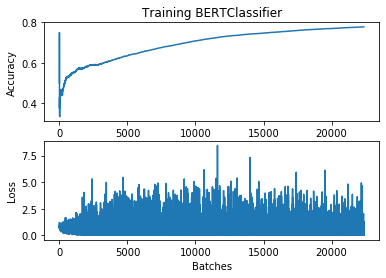

  0%|          | 0/3196 [00:00<?, ?it/s]

Time for [4 - train model - 0]: 4:03:11.373200


 10%|▉         | 312/3196 [02:01<22:01,  2.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 96%|█████████▌| 3070/3196 [19:44<00:47,  2.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[Epoch 2 Batch 5620/22369] loss=0.8428, lr=0.0000050, acc=0.910 - time 0:00:06.041920
[Epoch 2 Batch 5630/22369] loss=0.1998, lr=0.0000050, acc=0.910 - time 0:00:06.708820
[Epoch 2 Batch 5640/22369] loss=0.0136, lr=0.0000050, acc=0.910 - time 0:00:06.012723
[Epoch 2 Batch 5650/22369] loss=0.1870, lr=0.0000050, acc=0.910 - time 0:00:06.835922
[Epoch 2 Batch 5660/22369] loss=0.3548, lr=0.0000050, acc=0.910 - time 0:00:06.104646
[Epoch 2 Batch 5670/22369] loss=0.0922, lr=0.0000050, acc=0.910 - time 0:00:06.748514
Time for [epoch 2]: 1:00:52.742585
Time for [training]: 1:00:53.040954
Time for [4 - train model - 2]: 1:04:46.867474


KeyboardInterrupt: 

In [25]:
for epoch_id in range(3):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=2, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - last part", heatmap=False)

    model.save_parameters("data/bert.model.params")

In [61]:
for epoch_id in range(2):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=2, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - last part", heatmap=False)

    model.save_parameters("data/bert.model.params")

Time for [setup training]: 0:03:59.487021
loaded checkpoint for epoch 0
Time for [training]: 0:00:00.178236
no stats to plot
Time for [4 - train model - 0]: 0:03:59.667661


Time for [prediction]: 0:24:39.569987
Accuracy in epoch 0: 0.8501903917375202
Confusion Matrix:
[[8113  720]
 [2152 8186]]

Accuracy:  0.85 

Report for [BERTClassifier - last part]:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      8833
           1       0.92      0.79      0.85     10338

    accuracy                           0.85     19171
   macro avg       0.85      0.86      0.85     19171
weighted avg       0.86      0.85      0.85     19171

Time for [6 - evaluate - 0]: 0:24:42.025146


Time for [setup training]: 0:03:56.384011
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
Time for [training]: 0:00:00.289979
no stats to plot
Time for [4 - train model - 1]: 0:03:56.675587


Time for [prediction]: 0:24:44.409243
Accuracy in epoch 1: 0.8563455218820093
Confusion Matrix:
[[8476  357]
 [2397 7941]]

Accuracy:  0.86 

Report for [BERTClassifier - last part]:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      8833
           1       0.96      0.77      0.85     10338

    accuracy                           0.86     19171
   macro avg       0.87      0.86      0.86     19171
weighted avg       0.88      0.86      0.86     19171

Time for [6 - evaluate - 1]: 0:24:46.756546


In [60]:
from tqdm import tqdm_notebook as tqdm

*may need to use **binary_cross_entrophy**?* (can I use a single label or do I have to use "0" and "1"?)

### Cross topic - Training and evaluating model 

In [ ]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df)

In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [ ]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")